In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers.merge import Concatenate
from keras.models import model_from_json, Model
from keras.utils.vis_utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model
!python -m spacy download en_core_web_md 

     |████████████████████████████████| 96.4 MB 61.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
### Reading the text files that contains extracted questions and annotations

In [ ]:
questions = open('/content/drive/MyDrive/Preprocessed Data/ques.txt', 'rb').read().decode('utf-8').splitlines()
questions_len = open('/content/drive/MyDrive/Preprocessed Data/ques_len.txt', 'rb').read().decode('utf-8').splitlines()
answers = open('/content/drive/MyDrive/Preprocessed Data/answer.txt','rb').read().decode('utf-8').splitlines()
image_id = open('/content/drive/MyDrive/Preprocessed Data/images_id.txt','rb').read().decode('utf-8').splitlines()
vgg_path = "/content/drive/MyDrive/vgg_feats.mat"

In [ ]:
print(questions[0])
print(answers[0])
image_id[0]

What is the table made of?
wood


'350623'

In [ ]:
#You can take any index and its corresponding question, answer and image id. Just Visit http://cocodataset.org/#explore and type image id. You will get the image. So by this way you can check questions about images ans its answers.

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
vgg = scipy.io.loadmat(vgg_path)
features = vgg['feats']

In [ ]:
#Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. Hence we define upper limit as 1000 that is first 1000 most occuring words in vocabulary.

In [ ]:
def freq_answers(questions, answers, image_id, upper_lim):
    freq_ans = defaultdict(int)
    for ans in answers:
        freq_ans[ans] +=1
    
    sort = sorted(freq_ans.items(), key=operator.itemgetter(1), reverse=True)[0:upper_lim]
    #print(sort)
    top_ans, top_freq = zip(*sort)
    #print(top_ans, top_freq)
    new_answers_train = list()
    new_questions_train = list()
    new_images_train = list()
    for ans, ques, img in zip(answers, questions, image_id):
        if ans in top_ans:
            new_answers_train.append(ans)
            new_questions_train.append(ques)
            new_images_train.append(img)
    return (new_questions_train, new_answers_train, new_images_train)

In [ ]:
upper_lim = 1000
questions, answers, image_id = freq_answers(questions, answers, image_id, upper_lim)
questions_len, questions, answers, image_id = (list(t) for t in zip(*sorted(zip(questions_len, questions, answers, image_id))))
print (len(questions), len(answers),len(image_id))

105175 105175 105175


In [ ]:
le = LabelEncoder()
le.fit(answers)
pickle.dump(le, open('/content/drive/MyDrive/Preprocessed Data/label_encoder_lstm.pkl','wb'))

In [ ]:
### Defining model parameters

In [ ]:
batch_size               =      512
img_dim                  =     4096
word2vec_dim             =      300
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_lstm          =        3
dropout                  =       0.5
activation_mlp           =     'tanh'
num_epochs = 5

In [ ]:
img_ids = open('/content/drive/MyDrive/Preprocessed Data/coco_vgg_IDMap.txt','rb').read().decode('utf-8').splitlines()
id_map = dict()
for ids in img_ids:
    id_split = ids.split()
    id_map[id_split[0]] = int(id_split[1])
    #print(id_map)

In [ ]:
### Defining network architecture

In [ ]:
image_model = Sequential()
image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
model1 = Model(inputs = image_model.input, outputs = image_model.output)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 4096)]            0         
                                                                 
 reshape (Reshape)           (None, 4096)              0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()
language_model.add(LSTM(num_hidden_nodes_lstm,return_sequences=True, input_shape=(None, word2vec_dim)))

for i in range(num_layers_lstm-2):
    language_model.add(LSTM(num_hidden_nodes_lstm, return_sequences=True))
language_model.add(LSTM(num_hidden_nodes_lstm, return_sequences=False))

model2 = Model(language_model.input, language_model.output)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, None, 300)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 512)         1665024   
                                                                 
 lstm_1 (LSTM)               (None, None, 512)         2099200   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
Total params: 5,863,424
Trainable params: 5,863,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
combined = concatenate([image_model.output, language_model.output])

In [ ]:
model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(combined)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(upper_lim)(model)
model = Activation("softmax")(model)

model = Model(inputs=[image_model.input, language_model.input], outputs=model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, None, 300)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 512)    1665024     ['lstm_input[0][0]']             
                                                                                                  
 reshape_input (InputLayer)     [(None, 4096)]       0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 512)    2099200     ['lstm[0][0]']                   
                                                                                            

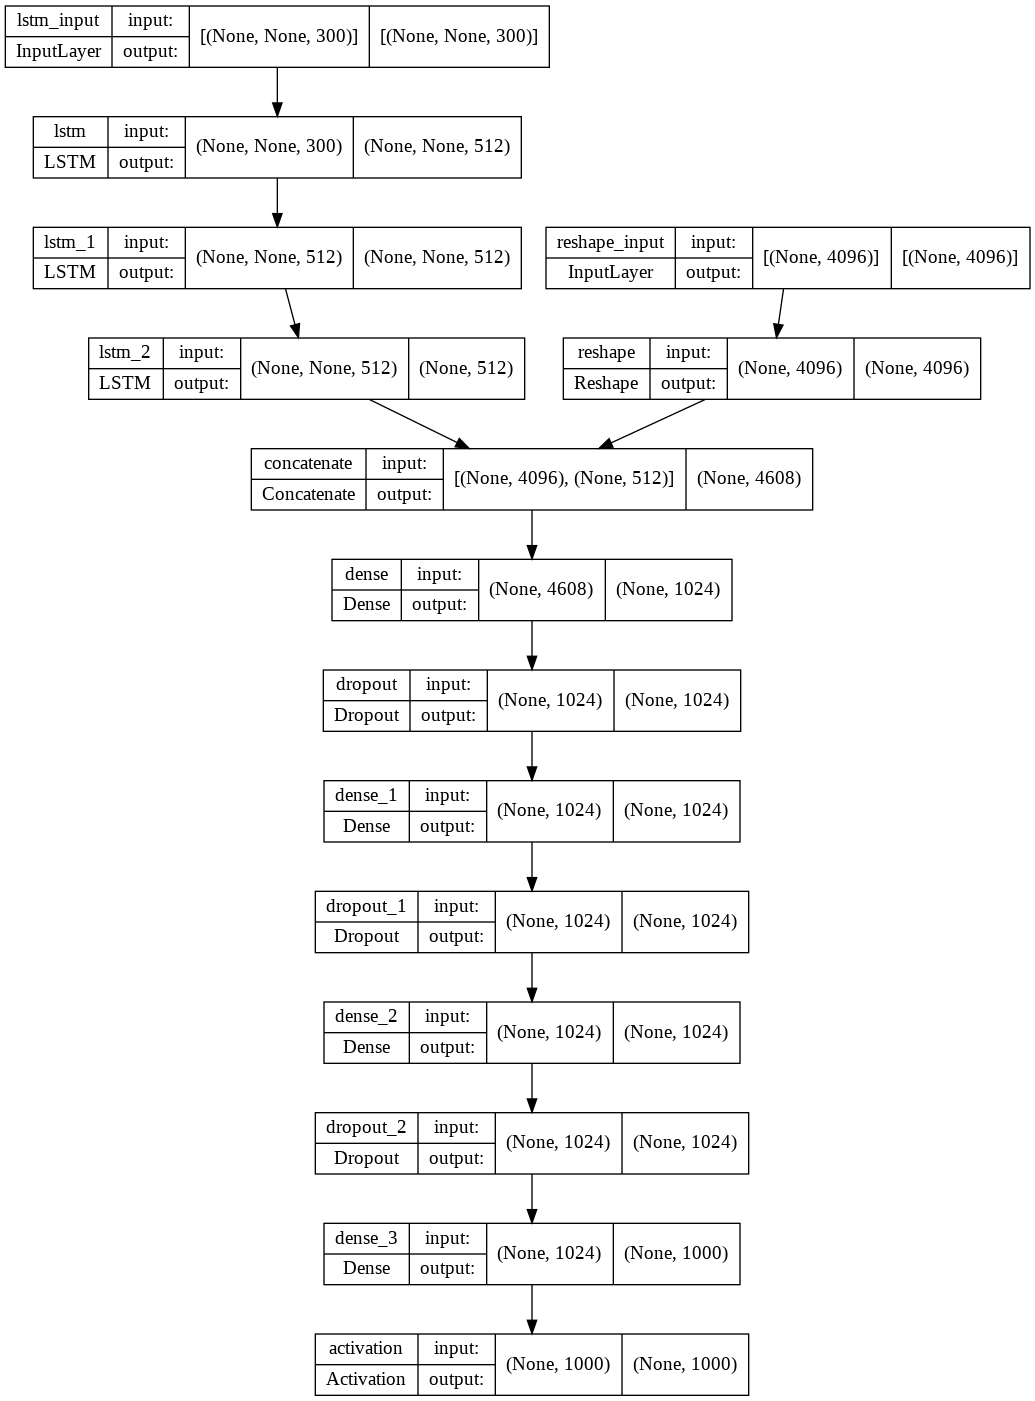

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def get_questions_tensor_timeseries(questions, nlp, timesteps):
    assert not isinstance(questions, list)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_tensor = np.zeros((nb_samples, timesteps, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            if j<timesteps:
                questions_tensor[i,j,:] = tokens[j].vector
    return questions_tensor

def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
    assert not isinstance(img_coco_ids, list)
    nb_samples = len(img_coco_ids)
    nb_dimensions = VGGfeatures.shape[0]
    image_matrix = np.zeros((nb_samples, nb_dimensions))
    #for j in range(len(img_coco_ids)):
     #   image_matrix[j,:] = VGGfeatures[:,img_map[img_coco_ids[j]]]
    #print (image_matrix)
    return image_matrix

def get_answers_sum(answers, encoder):
    assert not isinstance(answers, list)
    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    return Y

def grouped(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
   #print(args)
    #for a in(zip_longest(*args, fillvalue=fillvalue)):
        #print(a)
    return zip_longest(*args, fillvalue=fillvalue)

In [ ]:
### Train-Test Split

In [ ]:
train_questions = questions[:95000]
train_answers = answers[:95000]
train_image_id = image_id[:95000]

test_questions = questions[95000:]
test_answers = answers[95000:]
test_image_id = image_id[95000:]

In [ ]:
for k in range(num_epochs):
    print("Epoch Number: ",k+1)
    progbar = generic_utils.Progbar(len(train_questions))
    for question_batch, ans_batch, im_batch in zip(grouped(train_questions, batch_size, fillvalue=train_questions[-1]), 
                                               grouped(train_answers, batch_size, fillvalue=train_answers[-1]),
                                               grouped(train_image_id, batch_size, fillvalue=train_image_id[-1])):
        timestep = len(nlp(question_batch[-1]))
        X_ques_batch = get_questions_tensor_timeseries(question_batch, nlp, timestep)
        #print(X_ques_batch)
        X_img_batch = get_images_matrix(im_batch, id_map, features)
        Y_batch = get_answers_sum(ans_batch, le)
        #print(X_img_batch.shape)
        loss = model.train_on_batch(({'lstm_input' : X_ques_batch, 'reshape_input' : X_img_batch}), Y_batch)
        progbar.add(batch_size, values=[('train loss', loss)])
        

Epoch Number:  1
95232/95000 [==============================] - 1627s 17ms/step - train loss: 4.9355
Epoch Number:  2
95232/95000 [==============================] - 1600s 17ms/step - train loss: 4.5245
Epoch Number:  3
95232/95000 [==============================] - 1621s 17ms/step - train loss: 4.4429
Epoch Number:  4
95232/95000 [==============================] - 1583s 17ms/step - train loss: 4.4357
Epoch Number:  5
95232/95000 [==============================] - 1565s 16ms/step - train loss: 4.3203


In [ ]:
label_encoder = pickle.load(open('/content/drive/MyDrive/Preprocessed Data/label_encoder_lstm.pkl','rb'))

In [ ]:
y_pred = []
batch_size = 512 

#print ("Word2Vec Loaded!") 

widgets = ['Evaluating ', Percentage(), ' ', Bar(marker='#',left='[',right=']'), ' ', ETA()]
pbar = ProgressBar(widgets=widgets)

In [ ]:
for qu_batch,an_batch,im_batch in pbar(zip(grouped(test_questions, batch_size, 
                                                   fillvalue=test_questions[0]), 
                                           grouped(test_answers, batch_size, 
                                                   fillvalue=test_answers[0]), 
                                           grouped(test_image_id, batch_size, 
                                                   fillvalue=test_image_id[0]))):
    timesteps = len(nlp(qu_batch[-1]))
    X_ques_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)
    X_i_batch = get_images_matrix(im_batch, id_map, features)
    #X_batch = [X_ques_batch, X_i_batch]
    y_predict = model.predict(({'lstm_input' : X_ques_batch, 'reshape_input' : X_img_batch}))
    y_predict = np.argmax(y_predict,axis=1)
    y_pred.extend(label_encoder.inverse_transform(y_predict))

Evaluating N/A% [#                                             ] Time:  2:45:56


In [ ]:
correct_val = 0.0
total = 0


for pred, truth, ques, img in zip(y_pred, test_answers, test_questions, test_image_id):
    t_count = 0
    for _truth in truth.split(';'):
        if pred == truth:
            t_count += 1 
    if t_count >=1:
        correct_val +=1
    else:
        correct_val += float(t_count)/3

    total +=1

In [ ]:
print ("Accuracy: ", round((correct_val/total)*100,2))

Accuracy:  15.86


In [ ]:
model.save("model.h5")